# Building a Multi Layer perceptron for Language Identification

In [1]:
# Dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # for the optimizers (SDG, Adam ...)

from random import shuffle

torch.manual_seed(1) # Sets the seed for generating random numbers on all devices. Returns a torch.Generator object.

## Defining The Network

In [2]:
from pydantic import Field


class LanguageClassifier(nn.Module):
  def __init__(self,
               input_size = Field(..., description="The vocabulary size"),
               hidden_size= Field(..., description="The Hidden size"),
               output_size= Field(..., description="The number of classes here, languages")
               ):

    super(LanguageClassifier, self).__init__()

    self.input_size  = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size


    # Linear Layer : Wc + b
    self.linear1 = nn.Linear(self.input_size, self.hidden_size)
    self.linear2 = nn.Linear(self.hidden_size, self.output_size)


  def forward(self,X):
    """
      args:
          X:     [batch x input_size]
        output:
          probs: [batch x output_size]

    """


    if X.shape[1] != self.input_size:
      raise Exception(f"Input size does not match! The input size of the Batch {X.shape[1]} must match the input size of the Network {self.input_size}")


    X = self.linear1(X)   # 1st hidden layer
    X = F.sigmoid(X)      # Sigmoid Activation Function
    X = self.linear2(X)   # 2nd Hidden Layer

    log_probs = F.log_softmax(X,dim=1) # [b x output_size]

    return log_probs




In [3]:
# Testing my Network

tests =  [(10,100),(50,1000)]

classifier = LanguageClassifier(100, 80, 10)
for test in tests:

  print(f"Testing with batch size {test[0]} and input size {test[1]}")

  batch_size = test[0]
  input_size = test[1]

  x = torch.randn(batch_size, input_size)
  try:
    classifier(x)
  except Exception as e:
    print(f"{e}")


Testing with batch size 10 and input size 100
Testing with batch size 50 and input size 1000
Input size does not match! The input size of the Batch 1000 must match the input size of the Network 100


In [4]:
x = torch.randn(100, 10)
F.softmax(x,dim=1).shape

torch.Size([100, 10])

## CountVectorizer (my implementation)

In [5]:
# Toy Data

train_examples = [("me gusta comer en la cafeteria", "SPANISH"),
                  ("Give it to me", "ENGLISH"),
                  ("No creo que sea una buena idea", "SPANISH"),
                  ("No it is not a good idea to get lost at sea", "ENGLISH")]

test_examples = [("Yo creo que si", "SPANISH"),
                 ("it is lost on me", "ENGLISH")]

In [6]:
train_examples

[('me gusta comer en la cafeteria', 'SPANISH'),
 ('Give it to me', 'ENGLISH'),
 ('No creo que sea una buena idea', 'SPANISH'),
 ('No it is not a good idea to get lost at sea', 'ENGLISH')]

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from torch import Tensor
import numpy as np


vectorizer = TfidfVectorizer(analyzer="word")
encoder = LabelEncoder()



train_set = [x[0] for x in train_examples]
test_set  = [x[0] for x in test_examples]

y_train = [x[1] for x in train_examples]
y_test  = [x[1] for x in test_examples]


X_train = vectorizer.fit_transform(train_set)
X_test  = vectorizer.transform(test_set)

y_train = encoder.fit_transform(y_train)
y_test  = encoder.transform(y_test)


def to_tensor(A: np.ndarray, dtype: np.dtype) -> Tensor:
    if not isinstance(A, np.ndarray):
        raise TypeError(f"Expected np.ndarray, got {type(A)}")
    return torch.from_numpy(A.astype(dtype))


X_train = to_tensor(X_train.toarray(),np.float32)
X_test  = to_tensor(X_test.toarray() ,np.float32)

y_train = to_tensor(y_train, np.int16)
y_test  = to_tensor(y_test, np.int16)


print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)



print(len(encoder.classes_))



torch.Size([4, 22])
torch.Size([2, 22])
torch.Size([4])
torch.Size([2])
2


 ## Forward propagation (with random parameters)


In [8]:
classifier = LanguageClassifier(input_size=X_train.shape[1], hidden_size=20, output_size=len(encoder.classes_))

#  Test of forward propagation (with random parameters)

with torch.no_grad():

  log_probs = classifier(X_test)
  print("Log probabilities on test after training:")
  print(log_probs)

  y_pred = torch.argmax(log_probs,dim=1)
  print("Predicted classes: ",encoder.inverse_transform(y_pred))
  print("Gold classes: ",encoder.inverse_transform(y_test))

Log probabilities on test after training:
tensor([[-1.0401, -0.4360],
        [-1.0011, -0.4581]])
Predicted classes:  ['SPANISH' 'SPANISH']
Gold classes:  ['SPANISH' 'ENGLISH']


In [9]:
print(encoder.inverse_transform(y_pred))

['SPANISH' 'SPANISH']


In [10]:
print(y_train)

tensor([1, 0, 1, 0], dtype=torch.int16)


In [11]:
# Negative Log Likelihood loss function
loss_fn = nn.NLLLoss()
# The Gradient descent algorithm function
optimizer = optim.SGD(classifier.parameters(),lr=0.1)


epochs = 20
print("Training Phase\n")
for epoch in range(epochs):
  print(f"--Epoch {epoch+1}:--")


  # Shuffling
  indices = torch.randperm(X_train.size(0))
  X_train = X_train[indices]
  y_train = y_train[indices]


  # (re)sets all parameter gradients to 0
  classifier.zero_grad()

  print("Forward Propagation")
  log_probs = classifier(X_train)
  y_pred = torch.argmax(log_probs,dim=1)

  print(f"Gold classes: {y_train}")
  print(f"Predicted classes: {y_pred}")

  loss = loss_fn(log_probs,y_train.long())

  print(f"Loss: {loss}")
  loss.backward()

  optimizer.step()


print()
print("Prediction Phase\n")
with torch.no_grad():
  log_probs = classifier(X_test)

  y_pred = torch.argmax(log_probs,dim=1)
  print("Predicted classes: ",encoder.inverse_transform(y_pred))
  print("Gold classes: ",encoder.inverse_transform(y_test))









Training Phase

--Epoch 1:--
Forward Propagation
Gold classes: tensor([0, 0, 1, 1], dtype=torch.int16)
Predicted classes: tensor([1, 1, 1, 1])
Loss: 0.7283799052238464
--Epoch 2:--
Forward Propagation
Gold classes: tensor([1, 0, 0, 1], dtype=torch.int16)
Predicted classes: tensor([1, 1, 1, 1])
Loss: 0.7066543102264404
--Epoch 3:--
Forward Propagation
Gold classes: tensor([1, 1, 0, 0], dtype=torch.int16)
Predicted classes: tensor([1, 1, 1, 1])
Loss: 0.695549726486206
--Epoch 4:--
Forward Propagation
Gold classes: tensor([1, 0, 0, 1], dtype=torch.int16)
Predicted classes: tensor([1, 1, 1, 1])
Loss: 0.6898648738861084
--Epoch 5:--
Forward Propagation
Gold classes: tensor([1, 1, 0, 0], dtype=torch.int16)
Predicted classes: tensor([1, 1, 1, 1])
Loss: 0.6868504285812378
--Epoch 6:--
Forward Propagation
Gold classes: tensor([1, 0, 1, 0], dtype=torch.int16)
Predicted classes: tensor([1, 1, 1, 1])
Loss: 0.6851279139518738
--Epoch 7:--
Forward Propagation
Gold classes: tensor([0, 0, 1, 1], dtype

# Language Identification

## Fetching The Data

In [12]:
data_dir = './lang_identification_toy_dataset-ep-en-fr/'

import os

if not os.path.exists(data_dir):
  # shell commands can be run using !
  !pip install wget
  import wget

  # The URL for the dataset zip file.
  url = 'http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/lang_identification_toy_dataset-ep-en-fr.tgz'


  if not os.path.exists('./lang_identification_toy_dataset-ep-en-fr.tgz'):
    print('Downloading dataset')
    wget.download(url, './lang_identification_toy_dataset-ep-en-fr.tgz')
    !tar zxf lang_identification_toy_dataset-ep-en-fr.tgz

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=c88b07c5d9a84532c1f21cf36ddc0f2358ea76f42b0f5519e2e3976ef3713527
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [13]:
# The data files
!dir lang_identification_toy_dataset-ep-en-fr/

ep-en.tok.dev	ep-en.tok.train  ep-fr.tok.test
ep-en.tok.test	ep-fr.tok.dev	 ep-fr.tok.train


## Preprocessing:

In [14]:
import os
from pathlib import Path

class preprocessing:

  '''
  This class will return n lists
  The training dataset (list of tuple)
  The test dataset (list of tuple)
  '''
  def __init__(self,data_dir):
    self.data_dir = data_dir

    self.train_files = []
    self.test_files  = []
    self.dev_files   = []

    self.separate_sets()


  def separate_sets(self):
    for file in os.listdir(self.data_dir):
      if file.endswith(".train"):
        self.train_files.append(file)
      elif file.endswith(".test"):
        self.test_files.append(file)
      elif file.endswith(".dev"):
        self.dev_files.append(file)
      else:
        continue



  def read_file(self,filepath):
    with open(self.data_dir+filepath,'r',encoding='utf-8') as f:
      return f.readlines()


  def create_set(self,type_files:list):
    all_examples = []

    for file in type_files:
        if 'en' in file:
            result = [(line.strip(), 'ENGLISH') for line in self.read_file(file)]
        elif 'fr' in file:
            result = [(line.strip(), 'FRENCH') for line in self.read_file(file)]
        else:
            result = [(line.strip(), 'SPANISH') for line in self.read_file(file)]
        all_examples.extend(result)

    return all_examples





In [15]:
pre = preprocessing(data_dir)

train_examples = pre.create_set(pre.train_files)
test_examples  = pre.create_set(pre.test_files)
dev_examples   = pre.create_set(pre.dev_files)


print("sample of train examples:" , train_examples[0])
print("sample of test  examples:" , test_examples[0])
print("sample of dev   examples:" , dev_examples[0])

print()

print("size train examples:",len(train_examples))
print("size test  examples:",len(test_examples))
print("size dev   examples:",len(dev_examples))

sample of train examples: ('Resumption of the session', 'ENGLISH')
sample of test  examples: ("Le rapport sur l' Ancienne république yougoslave de Macédoine salue ce qui a été réalisé par la mise en œuvre de l' accord-cadre d' Okhrid , qui traite l' aspect politique des relations interethniques .", 'FRENCH')
sample of dev   examples: ("Cette nouvelle république n' a pas encore appris les pratiques diplomatiques européennes , ayant placé ses espoirs sur l' adhésion à l' OTAN , simplement à cause de promesses des États-Unis et d' espoirs infantiles et malavisés de libération de l' esclavage .", 'FRENCH')

size train examples: 1000
size test  examples: 200
size dev   examples: 200


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from torch import Tensor
import numpy as np


vectorizer = TfidfVectorizer(analyzer="word")
encoder = LabelEncoder()



train_set = [x[0] for x in train_examples]
test_set  = [x[0] for x in test_examples]
dev_set   = [x[0] for x in dev_examples]

y_train = [x[1] for x in train_examples]
y_test  = [x[1] for x in test_examples]
y_dev   = [x[1] for x in dev_examples]


X_train = vectorizer.fit_transform(train_set)
X_test  = vectorizer.transform(test_set)
X_dev   = vectorizer.transform(dev_set)

y_train = encoder.fit_transform(y_train)
y_test  = encoder.transform(y_test)
y_dev   = encoder.transform(y_dev)


def to_tensor(A: np.ndarray, dtype: np.dtype) -> Tensor:
    if not isinstance(A, np.ndarray):
        raise TypeError(f"Expected np.ndarray, got {type(A)}")
    return torch.from_numpy(A.astype(dtype))


X_train = to_tensor(X_train.toarray(),np.float32)
X_test  = to_tensor(X_test.toarray() ,np.float32)
X_dev   = to_tensor(X_dev.toarray()  ,np.float32)

y_train = to_tensor(y_train, np.int16)
y_test  = to_tensor(y_test, np.int16)
y_dev   = to_tensor(y_dev, np.int16)


print(X_train.shape)
print(X_test.shape)
print(X_dev.shape)

print(y_train.shape)
print(y_test.shape)
print(y_dev.shape)

print(len(encoder.classes_))

torch.Size([1000, 4204])
torch.Size([200, 4204])
torch.Size([200, 4204])
torch.Size([1000])
torch.Size([200])
torch.Size([200])
2


In [92]:
from torch.utils.data import DataLoader, TensorDataset

classifier = LanguageClassifier(input_size=X_train.shape[1], hidden_size=20, output_size=len(encoder.classes_))

def training(epochs:int,
             batch_size:int,
             classifier:LanguageClassifier,
             X_train:Tensor,
             y_train:Tensor,
             X_dev:Tensor,
             y_dev:Tensor
             ):
  '''
  Training loop
  args:
    epochs: number of epochs
    batch_size: batch size
  '''

  train_dataset = TensorDataset(X_train, y_train) # Combine features and labels into a dataset
  train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   # Create a DataLoader for batching and shuffling
  dev_loader    = DataLoader(TensorDataset(X_dev, y_dev), batch_size=batch_size, shuffle=False)



  loss_fn = nn.NLLLoss()                                  # Negative Log Likelihood loss function
  optimizer = optim.SGD(classifier.parameters(),lr=0.1)   # The Gradient descent algorithm function


  # Training Phase
  train_losses = []
  dev_losses   = []

  print("Training Phase\n")

  for epoch in range(epochs):

    print(f"--Epoch {epoch+1}:--")
    classifier.train()

    batch_loss = []
    for x_batch, y_batch in train_loader:

        classifier.zero_grad() # (re)sets all parameter gradients to 0

        # Forward Propagation
        log_probs = classifier(x_batch)
        y_pred    = torch.argmax(log_probs,dim=1)
        loss      = loss_fn(log_probs,y_batch.long())

        # Compute the loss of the i-th batch
        batch_loss.append(loss.item())

        # Back Propagation
        loss.backward()
        optimizer.step()

    # End of Batch loop
    print(f"{'Training Loss':<20} {sum(batch_loss)/len(batch_loss)}")
    train_losses.append(sum(batch_loss)/len(batch_loss))


    classifier.eval()

    batch_loss = []
    with torch.no_grad():

      for x_dev_batch, y_dev_batch in dev_loader:
          log_probs = classifier(x_dev_batch)
          y_pred = torch.argmax(log_probs,dim=1)
          loss = loss_fn(log_probs,y_dev_batch.long())
          batch_loss.append(loss)

    print(f"{'Validation Loss':<20} {sum(batch_loss)/len(batch_loss)}")
    print()
    dev_losses.append((sum(batch_loss)/len(batch_loss)).item())

  return {
    "train_losses": train_losses,
    "dev_losses": dev_losses,
    }


In [93]:
losses = training(epochs=100,
                                    batch_size=32,
                                    classifier=classifier,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_dev=X_dev,
                                    y_dev=y_dev
                                    )

Training Phase

--Epoch 1:--
Training Loss        0.6979603841900826
Validation Loss      0.6873841881752014

--Epoch 2:--
Training Loss        0.6940223425626755
Validation Loss      0.6864941716194153

--Epoch 3:--
Training Loss        0.6940965410321951
Validation Loss      0.7092852592468262

--Epoch 4:--
Training Loss        0.6934899501502514
Validation Loss      0.7275482416152954

--Epoch 5:--
Training Loss        0.6921533532440662
Validation Loss      0.6852025985717773

--Epoch 6:--
Training Loss        0.6924932226538658
Validation Loss      0.6847612261772156

--Epoch 7:--
Training Loss        0.691999239847064
Validation Loss      0.6878184676170349

--Epoch 8:--
Training Loss        0.6874970812350512
Validation Loss      0.6971451640129089

--Epoch 9:--
Training Loss        0.6895400788635015
Validation Loss      0.6936476826667786

--Epoch 10:--
Training Loss        0.6863024588674307
Validation Loss      0.6763167381286621

--Epoch 11:--
Training Loss        0.6828274

## Visualisation

In [94]:
import pandas as pd

epochs = list(range(1, len(train_losses) + 1))
df = pd.DataFrame({
    "Epoch": epochs * 2,
    "Loss": losses['train_losses'] + losses["dev_losses"],
    "Type": ["Train"] * len(losses['train_losses'] ) + ["Dev"] * len(losses['train_losses'] )
})


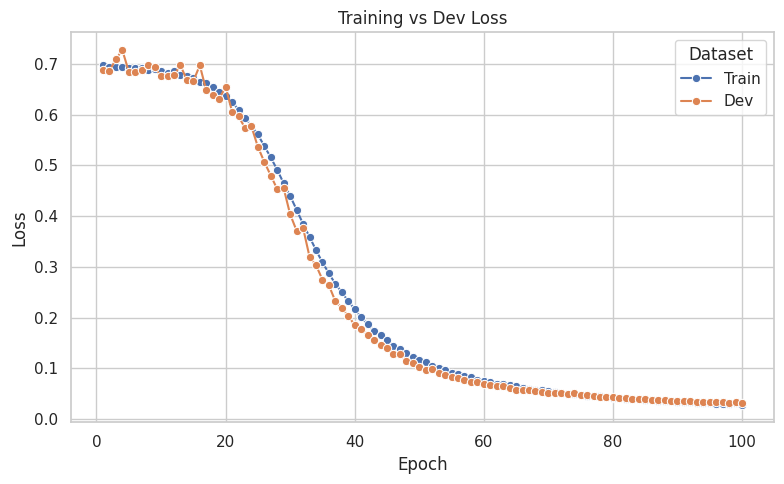

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Type", marker="o")

plt.title("Training vs Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


## Inference

In [91]:
with torch.no_grad():
  log_probs = classifier(X_test)
  y_pred = torch.argmax(log_probs,dim=1)

# Accuracy



  print(f"{'Test Loss':<20} {loss.item()}")
  #print("Predicted classes: ",encoder.inverse_transform(y_pred))
  #print("Gold classes: ",encoder.inverse_transform(y_test))


Test Loss            0.02533319778740406
Predicted classes:  ['FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH'
 'FRENCH' 'FRENCH' 'FRENCH' 'FRENCH' 'ENGLISH' 'ENGLISH' 'ENGLI